# Conditional GAN for generation


In [ ]:
%pip install h5py scikit-learn torch torchvision tqdm safetensors autograd > /dev/null

In [1]:
import os
from urllib.parse import urlparse
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Custom TQDM progress bar for urllib downloads."""
    def update_to(self, blocks=1, block_size=1, total_size=None):
        """
        Update the progress bar.

        Args:
            blocks (int): Number of blocks transferred so far.
            block_size (int): Size of each block (in bytes).
            total_size (int, optional): Total size of the file (in bytes).
        """
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)


def download(url, target_dir):
    """
    Download a file from a URL into the target directory with progress display.

    Args:
        url (str): Direct URL to the file.
        target_dir (str): Directory to save the file.

    Returns:
        str: Path to the downloaded (or existing) file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Infer the filename from the URL
    filename = os.path.basename(urlparse(url).path)
    local_path = os.path.join(target_dir, filename)

    # If file already exists, skip download
    if os.path.exists(local_path):
        print(f"✅ File already exists: {local_path}")
        return local_path

    # Download with progress bar
    print(f"⬇️  Downloading {filename} from {url}")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=local_path, reporthook=t.update_to)

    print(f"✅ Download complete: {local_path}")
    return local_path

In [2]:

dataset_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_GUN_PATCHSIZE_11.h5"
data_dir = "data"
dataset_path = download(dataset_url, data_dir)



✅ File already exists: data/CNN4FCAL_GUN_PATCHSIZE_11.h5


```{note}
This is exactly the same as in [CNN for Regression](./02-cnn-regression.ipynb). 
```

We are using the same `.h5` dataset for regression. when we process it, We will be simply selecting out photons only to perform our training

### Step 1: Open and Inspect the `.h5` File

We can open the dataset and confirm whats inside it


In [3]:
import h5py, numpy as np
with h5py.File(dataset_path, "r") as f:
    print("✅ Datasets available:", list(f.keys()))
    print("🔍 patches shape:", f["patches"].shape)
    print("🔍 labels shape:", f["label"].shape)

✅ Datasets available: ['label', 'patches', 'showerE', 'thrownE']
🔍 patches shape: (814151, 11, 11)
🔍 labels shape: (814151,)


### Step 2: Create a Custom PyTorch Dataset

This dataset will:

* Read directly from the `.h5` file
* Optionally we can apply normalization in the form of transformation

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np # Import numpy

class FCALPatchPhotonDataset(Dataset):
    def __init__(self, h5_path, indices=None, transform=None, thrownNormalize=True):
        """
        Parameters
        ----------
        h5_path : str
            Path to the HDF5 file.
        indices : list or np.ndarray, optional
            Subset of indices to use (for train/val/test split).
        transform : callable, optional
            Optional transform to apply to each patch.
        """
        # Open the file handle here and keep it open
        self.h5_path = h5_path
        self.file = h5py.File(self.h5_path, "r")
        self.indices = indices
        self.transform = transform
        self.minthrowE = 0.0
        self.maxthrowE = 4.0  # GeV

        # Assign datasets directly from the file handle
        self.length = len(self.file["label"])
        self.labels = np.array(self.file["label"], dtype=np.int64)
        self.labels = self.labels[self.indices if self.indices is not None else slice(None)]
        self.patches = np.array(self.file["patches"], dtype=np.float32)
        self.patches = self.patches[self.indices] if self.indices is not None else self.patches
        self.showerE = np.array(self.file["showerE"], dtype=np.float32)
        self.showerE = self.showerE[self.indices if self.indices is not None else slice(None)]
        self.thrownE = np.array(self.file["thrownE"], dtype=np.float32)
        self.thrownE = self.thrownE[self.indices if self.indices is not None else slice(None)] 
        self.file.close()

        # lets select only photons
        self.photon_indices = np.where(self.labels == 1)
        self.length = len(self.photon_indices)
        
        self.labels = self.labels[self.photon_indices]
        self.patches = self.patches[self.photon_indices]
        self.showerE = self.showerE[self.photon_indices]
        self.thrownE = self.thrownE[self.photon_indices]

        if thrownNormalize:
            self.thrownE = ( self.thrownE - self.minthrowE ) / ( self.maxthrowE - self.minthrowE )  # Normalize by 100 GeV
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Handle subset indices

        # Access data directly from the assigned attributes
        patch = self.patches[idx]
        label = self.labels[idx]
        showerE = self.showerE[idx]
        thrownE = self.thrownE[idx]

        # Optional transform
        if self.transform:
            patch = self.transform(patch)

        # Convert to torch tensors
        patch = torch.from_numpy(patch).unsqueeze(0)  # (1, 11, 11)
        return patch, label, showerE, thrownE

### Step 3: Create Dataset and DataLoader Objects

The entire dataset will be used for training here. Let us normalize each of the images with the total energy of all the hits in the shower

In [5]:


ENERGY_SCALE  = 0.05    # GeV (for global log scaling)
CLIP_MAX      = 2.0     # GeV per cell clamp for scaling
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
BATCH_SIZE    = 512
NUM_WORKERS = 1
pin = (DEVICE == "cuda")

def log_global_norm(W, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Keep everything float32 to avoid silent upcasts to float64
    W    = W.clip(min=0).astype(np.float32, copy=False)
    e0   = np.float32(e0)
    emax = np.float32(emax)
    Z = np.log1p(W / e0).astype(np.float32, copy=False)
    Z /= np.log1p(emax / e0).astype(np.float32, copy=False)
    np.clip(Z, 0.0, 1.0, out=Z)
    return Z  # float32

def inv_log_global_norm(Z, e0=ENERGY_SCALE, emax=CLIP_MAX):
    return e0 * (np.expm1(Z * np.log1p(emax / e0)))


def normalize_patch(patch):
    # Example normalization to total energy = 1
    total = np.sum(patch)
    return patch / total if total > 0 else patch

train_ds = FCALPatchPhotonDataset(dataset_path,transform=log_global_norm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True
                          )


In [6]:
# lets check a few samples

patches, labels, showerE, thrownE = next(iter(train_loader))
print("Batch shape:", patches.shape)    # (B, 1, 11, 11)
print("Labels:", labels[:8])
print("showerE:", showerE[:8])
print("thrownE:", thrownE[:8])

Batch shape: torch.Size([512, 1, 11, 11])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
showerE: tensor([0.3045, 3.1794, 2.0084, 3.4232, 0.6941, 0.9482, 2.5017, 2.0806])
thrownE: tensor([0.3510, 3.2682, 1.9446, 3.1843, 0.7859, 1.0541, 2.7125, 1.9831])


### Step 4: Diagnostic plots

Let us make a few diagnostic plots. We will be using these plots for visual comparison between generated samples and true distributions.

In [51]:
def compute_patch_metrics(patches: torch.Tensor, thrownE: torch.Tensor, patch_size = 11) -> dict:
    """
    Compute metrics for a batch of patches.

    Parameters
    ----------
    patches : torch.Tensor
        Tensor of shape (B, 1, 11, 11) representing the patches.
    thrownE : torch.Tensor
        Tensor of shape (B,) representing the thrown energies.

    Returns
    -------
    dict
        Dictionary containing numHits, rows, cols, energies, total energy (sum), max cell energy, E1/E9 ratio, E9/E25 ratio, and energy-weighted centroid for each patch.
    """
    
    B = patches.shape[0]
    assert patches.shape == (B, 1, patch_size, patch_size)
    assert thrownE.shape == (B,)

    # Remove channel dimension
    patches = patches.squeeze(1)  # (B, 11, 11)

    # Number of hits (cells with energy > 0)
    threshold = 0.050  # GeV
    patches = patches * (patches > threshold)  # Zero out cells below threshold
    numHits = (patches > 0).sum(dim=(1, 2))  # (B,)

    # Row and column indices of hits
    _, rows, cols = torch.nonzero(patches > 0, as_tuple=True)  # (N_hits,), (N_hits,)
    hit_batch_indices = rows // patch_size  # Determine which batch each hit belongs to
    rows = rows %   patch_size
    cols = cols % patch_size

    # Energies of hits
    energies = patches[patches > 0]  # (N_hits,)

    # Total energy in each patch
    total_energy = patches.sum(dim=(1, 2))  # (B,)

    # Max cell energy in each patch
    max_cell_energy, _ = patches.view(B, -1).max(dim=1)  # (B,)

    # E1/E9 ratio
    e1 = max_cell_energy  # (B,)
    e9 = torch.zeros(B, device=patches.device)  # (B,)
    for b in range(B):
        if numHits[b] > 0:
            max_idx = torch.argmax(patches[b])
            r, c = divmod(max_idx.item(), patch_size)
            r_min = max(r - 1, 0)
            r_max = min(r + 2, patch_size)
            c_min = max(c - 1, 0)
            c_max = min(c + 2, patch_size)
            e9[b] = patches[b, r_min:r_max, c_min:c_max].sum()
    e1_e9_ratio = e1 / e9.clamp(min=1e-6)  # Avoid division by zero

    # E9/E25 ratio
    e25 = torch.zeros(B, device=patches.device)  # (B,)
    for b in range(B):
        if numHits[b] > 0:
            max_idx = torch.argmax(patches[b])
            r, c = divmod(max_idx.item(), patch_size)
            r_min = max(r - 2, 0)
            r_max = min(r + 3, patch_size)
            c_min = max(c - 2, 0)
            c_max = min(c + 3, patch_size)
            e25[b] = patches[b, r_min:r_max, c_min:c_max].sum()
    e9_e25_ratio = e9 / e25.clamp(min=1e-6)  # Avoid division by zero
    # Energy-weighted centroid
    centroids = []
    for b in range(B):
        if total_energy[b] > 0:
            r_indices = torch.arange(patch_size, device=patches.device).view(1, -1).expand(11, 11)
            c_indices = torch.arange(patch_size, device=patches.device).view(-1, 1).expand(11, 11)
            weighted_r = (patches[b] * r_indices).sum() / total_energy[b]
            weighted_c = (patches[b] * c_indices).sum() / total_energy[b]
            centroids.append((weighted_r.item(), weighted_c.item()))
        else:
            centroids.append((-1.0, -1.0))  # Indicate no hits with -1
    centroids = np.array(centroids)  # (B, 2)
    return {
        "numHits": numHits.cpu().numpy(),
        "rows": rows.cpu().numpy(),
        "cols": cols.cpu().numpy(),
        "energies": energies.cpu().numpy(),
        "total_energy": total_energy.cpu().numpy(),
        "max_cell_energy": max_cell_energy.cpu().numpy(),
        "e1_e9_ratio": e1_e9_ratio.cpu().numpy(),
        "e9_e25_ratio": e9_e25_ratio.cpu().numpy(),
        "centroids": centroids
    }
    

def plot_patch_metrics(metrics: dict, title = "Patch Metrics", save_path = None):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    
    axs[0, 0].hist(metrics["numHits"], bins=30, color='blue', alpha=0.7)
    axs[0, 0].set_title("Number of Hits per Patch")
    axs[0, 0].set_xlabel("Number of Hits")
    axs[0, 0].set_ylabel("Frequency")

    axs[0, 1].hist(metrics["total_energy"], bins=100, range = (0., 4.0), color='green', alpha=0.7)
    axs[0, 1].set_title("Total Energy per Patch")
    axs[0, 1].set_xlabel("Total Energy (GeV)")
    axs[0, 1].set_ylabel("Frequency")

    axs[0, 2].hist(metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='red', alpha=0.7)
    axs[0, 2].set_title("Max Cell Energy per Patch")
    axs[0, 2].set_xlabel("Max Cell Energy (GeV)")
    axs[0, 2].set_ylabel("Frequency")

    axs[1, 0].hist(metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='purple', alpha=0.7)
    axs[1, 0].set_title("E1/E9 Ratio")
    axs[1, 0].set_xlabel("E1/E9")
    axs[1, 0].set_ylabel("Frequency")

    axs[1, 1].hist(metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='orange', alpha=0.7)
    axs[1, 1].set_title("E9/E25 Ratio")
    axs[1, 1].set_xlabel("E9/E25")
    axs[1, 1].set_ylabel("Frequency")
    # make y log scale
    axs[1, 1].set_yscale('log')

    centroids = metrics["centroids"]
    axs[1, 2].hist(centroids[:, 0], bins=50, color='purple', alpha=0.7)
    axs[1, 2].set_title("Energy-weighted Centroids (along Row)")
    axs[1, 2].set_xlabel("Rows")
    axs[1, 2].set_ylabel("Frequency")
    
    axs[2, 0].hist(centroids[:, 1], bins=50, color='cyan', alpha=0.7)
    axs[2, 0].set_title("Energy-weighted Centroids (along Column)")
    axs[2, 0].set_xlabel("Column Index")
    axs[2, 0].set_ylabel("Frequency")

    axs[2, 1].hist(metrics["rows"], bins=11, range=(0, 11), color='cyan', alpha=0.7)
    axs[2, 1].set_title("Hit Row Indices")
    axs[2, 1].set_xlabel("Row Index")
    axs[2, 1].set_ylabel("Frequency")

    axs[2, 2].hist(metrics["cols"], bins=11, range=(0, 11), color='magenta', alpha=0.7)
    axs[2, 2].set_title("Hit Column Indices")
    axs[2, 2].set_xlabel("Column Index")
    axs[2, 2].set_ylabel("Frequency")
    
    axs[3, 0].hist(metrics["energies"], bins=200, range = (0., 2.), color='brown', alpha=0.7)
    axs[3, 0].set_title("Hit Cell Energies")
    axs[3, 0].set_xlabel("Cell Energy (GeV)")
    axs[3, 0].set_ylabel("Frequency")
    # make it log y
    axs[3, 0].set_yscale('log')
    
    # lets switch off the last two subplots
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def compare_plot(generator_metrics: dict, true_patch_metrics: dict, save_path = None):
    import matplotlib.pyplot as plt
    

    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    
    # Lets make sure the histograms are not filled but has two patterns for linestyle and color is blue and red
    axs[0, 0].hist(generator_metrics["numHits"], bins=30, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 0].hist(true_patch_metrics["numHits"], bins=30, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 0].set_title("Number of Hits per Patch")
    axs[0, 0].set_xlabel("Number of Hits")
    axs[0, 0].set_ylabel("Frequency")
    axs[0, 0].legend()
    
    axs[0, 1].hist(generator_metrics["total_energy"], bins=100, range = (0., 4.0), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 1].hist(true_patch_metrics["total_energy"], bins=100, range = (0., 4.0), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 1].set_title("Total Energy per Patch")
    axs[0, 1].set_xlabel("Total Energy (GeV)")
    axs[0, 1].set_ylabel("Frequency")
    axs[0, 1].legend()
    
    axs[0, 2].hist(generator_metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 2].hist(true_patch_metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 2].set_title("Max Cell Energy per Patch")
    axs[0, 2].set_xlabel("Max Cell Energy (GeV)")
    axs[0, 2].set_ylabel("Frequency")
    axs[0, 2].legend()
    axs[1, 0].hist(generator_metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 0].hist(true_patch_metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 0].set_title("E1/E9 Ratio")
    axs[1, 0].set_xlabel("E1/E9")
    axs[1, 0].set_ylabel("Frequency")
    axs[1, 0].legend()
    
    axs[1, 1].hist(generator_metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 1].hist(true_patch_metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 1].set_title("E9/E25 Ratio")
    axs[1, 1].set_xlabel("E9/E25")
    axs[1, 1].set_ylabel("Frequency")
    axs[1, 1].set_yscale('log')
    axs[1, 1].legend()
    
    gen_centroids = generator_metrics["centroids"]
    disc_centroids = true_patch_metrics["centroids"]
    axs[1, 2].hist(gen_centroids[:, 0], bins=50, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 2].hist(disc_centroids[:, 0], bins=50, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 2].set_title("Energy-weighted Centroids (along Row)")
    axs[1, 2].set_xlabel("Rows")
    axs[1, 2].set_ylabel("Frequency")
    axs[1, 2].legend()
    
    axs[2, 0].hist(gen_centroids[:, 1], bins=50, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 0].hist(disc_centroids[:, 1], bins=50, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 0].set_title("Energy-weighted Centroids (along Column)")
    axs[2, 0].set_xlabel("Column Index")
    axs[2, 0].set_ylabel("Frequency")
    axs[2, 0].legend()
    
    axs[2, 1].hist(generator_metrics["rows"], bins=11, range=(0, 11), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 1].hist(true_patch_metrics["rows"], bins=11, range=(0, 11), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 1].set_title("Hit Row Indices")
    axs[2, 1].set_xlabel("Row Index")
    axs[2, 1].set_ylabel("Frequency")
    axs[2, 1].legend()
    
    axs[2, 2].hist(generator_metrics["cols"], bins=11, range=(0, 11), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 2].hist(true_patch_metrics["cols"], bins=11, range=(0, 11), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 2].set_title("Hit Column Indices")
    axs[2, 2].set_xlabel("Column Index")
    axs[2, 2].set_ylabel("Frequency")
    axs[2, 2].legend()
    
    axs[3, 0].hist(generator_metrics["energies"], bins=200, range = (0., 2.), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[3, 0].hist(true_patch_metrics["energies"], bins=200, range = (0., 2.), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[3, 0].set_title("Hit Cell Energies")
    axs[3, 0].set_xlabel("Cell Energy (GeV)")
    axs[3, 0].set_ylabel("Frequency")
    axs[3, 0].set_yscale('log')
    axs[3, 0].legend()
    
    # lets switch off the last two subplots
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    
    plt.suptitle("Generated vs True Showers Patch Metrics", fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

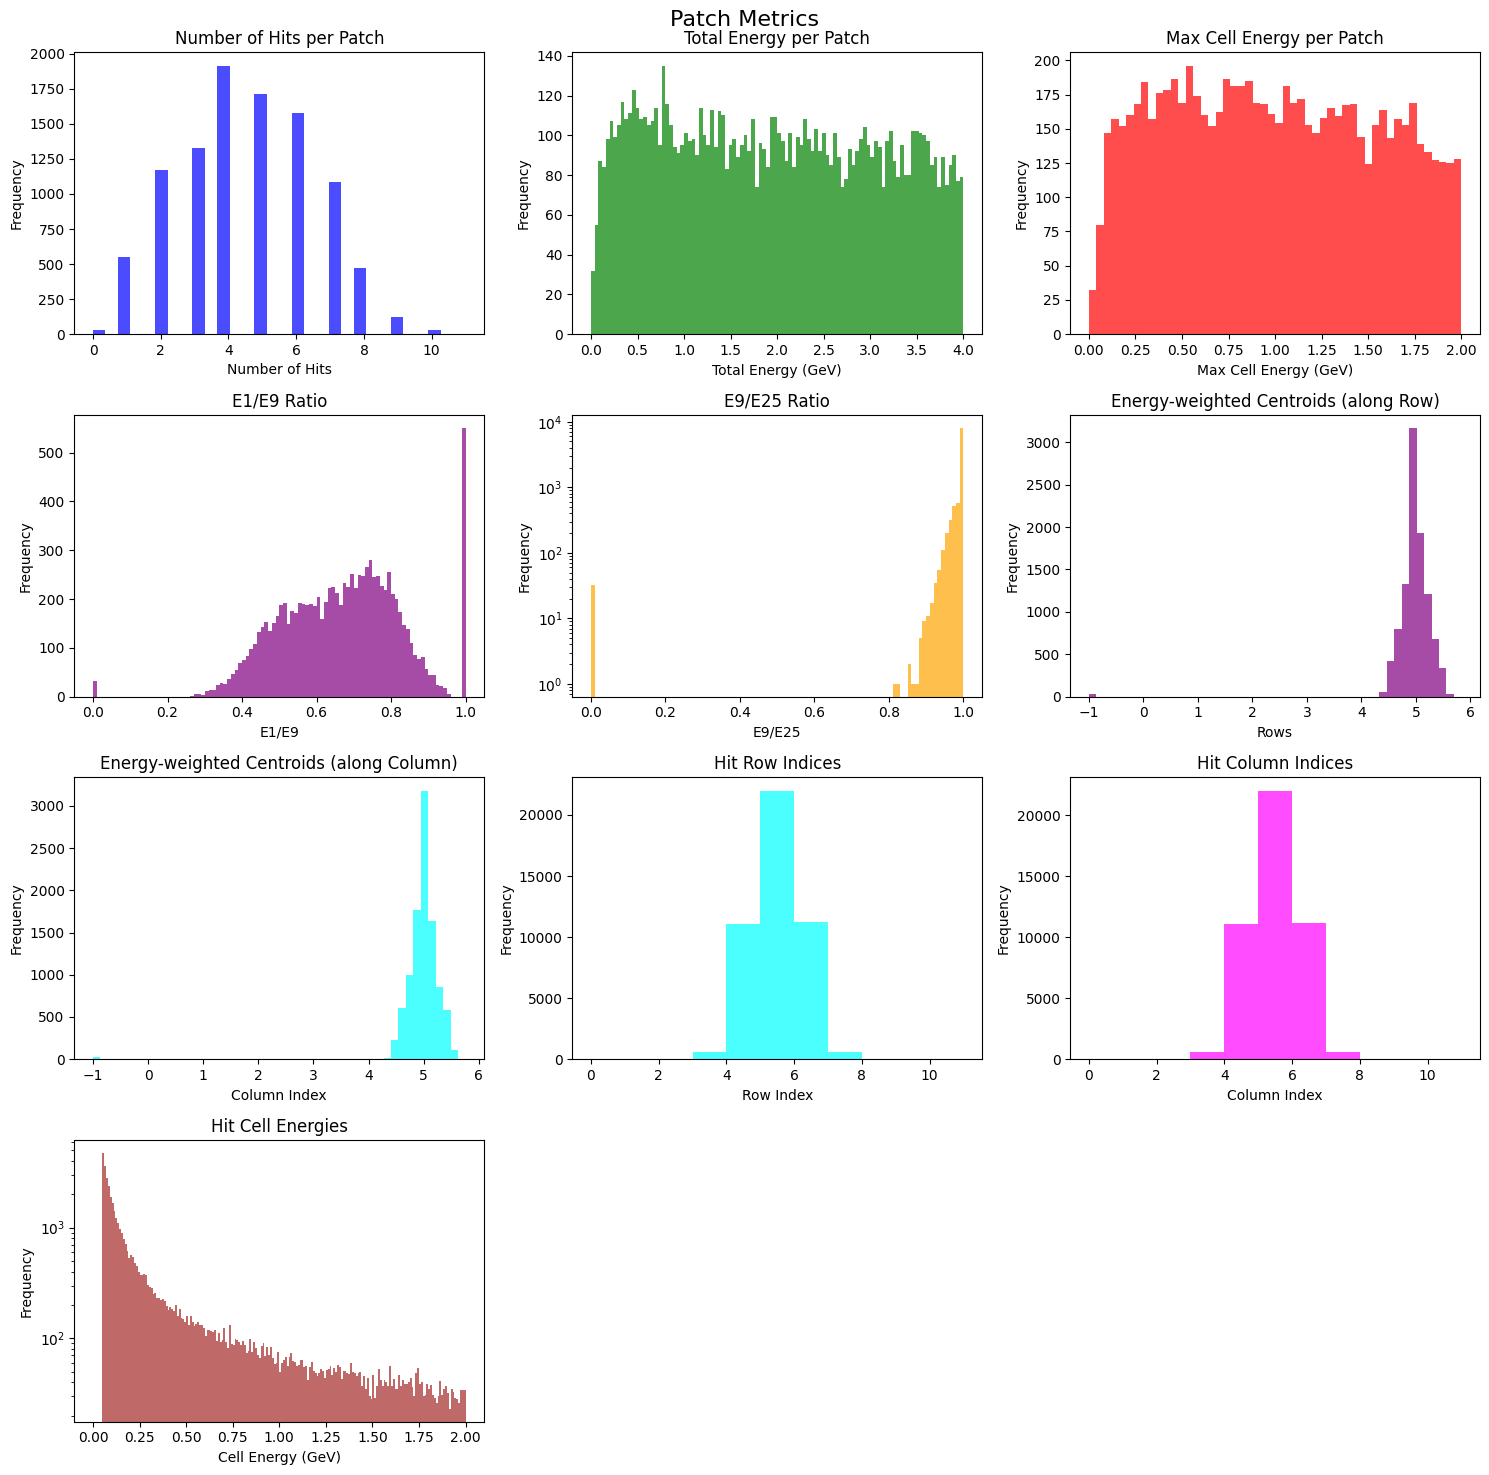

In [52]:
num_samples = 10_000
# lets randomly sample 10k patches from the dataset
indices = np.random.choice(len(train_ds), size=num_samples, replace=False)
patches = torch.from_numpy(train_ds.patches[indices]).unsqueeze(1)  # (N, 1, 11, 11)
thrownE = torch.from_numpy(train_ds.thrownE[indices])  # (N,)
patches_metrics = compute_patch_metrics(patches, thrownE)
plot_patch_metrics(patches_metrics)

## GAN architecture

In [ ]:
import torch
import torch.nn as nn
from safetensors.torch import save_file
from tqdm import tqdm
import numpy as np
from contextlib import nullcontext
import autograd
# ---------------------------
# Configuration
# ---------------------------
PATCH_SIZE   = 11  # or whatever your patch dimension is
LATENT_DIM   = 64
COND_DIM     = 1   # thrownE normalized
HIDDEN_CH    = 64
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
LR           = 2e-4
BETA1, BETA2 = 0.0, 0.9
EPOCHS       = 100
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
LAMBDA_GP    = 15.0
N_CRITIC     = 2  # number of D updates per G update


print (f"Using device: {DEVICE}, AMP: {USE_AMP}")
# ---------------------------
# conditional vector and random noise
# ---------------------------
def generate_latent_vector(size, latent_dim=LATENT_DIM):
    return torch.randn(size, latent_dim, device=DEVICE)
def sample_condition_vector(thrownE, size):
    indices = np.random.choice(len(thrownE), size, replace=False)
    return thrownE[indices]

class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, cond_dim=COND_DIM, patch=11):
        super().__init__()
        self.patch = patch
        h0 = patch // 4  # = 2 for patch=11
        C = HIDDEN_CH

        self.fc = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128), nn.ReLU(True),
            nn.Linear(128, 256), nn.ReLU(True),
            nn.Linear(256, C * h0 * h0), nn.ReLU(True)
        )

        # 2x2 -> 4x4 (k=4,s=2,p=1)
        # 4x4 -> 8x8 (k=4,s=2,p=1)
        # 8x8 -> 11x11 (k=4,s=1,p=0)   <-- key fix
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(C // 2), nn.ReLU(True),

            nn.ConvTranspose2d(C // 2, C // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(C // 4), nn.ReLU(True),

            nn.ConvTranspose2d(C // 4, 1, kernel_size=4, stride=1, padding=0)
            # WGAN-GP: no Sigmoid here
        )

    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        x = self.fc(x)
        x = x.view(-1, HIDDEN_CH, self.patch // 4, self.patch // 4)  # (B,C,2,2)
        x = self.deconv(x)  # (B,1,11,11)
        assert x.shape[-1] == self.patch and x.shape[-2] == self.patch, f"Got {x.shape}"
        return x

# ---------------------------
# Discriminator
# ---------------------------
class Discriminator(nn.Module):
    def __init__(self, cond_dim=COND_DIM, patch=PATCH_SIZE):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Flatten + conditional projection
        conv_out_dim = (patch // 4) * (patch // 4) * 64
        self.fc = nn.Sequential(
            nn.Linear(conv_out_dim + cond_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, img, cond):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, cond], dim=1)
        return self.fc(x)


# ---------------------------
# Gradient Penalty
# ---------------------------
def compute_gradient_penalty(D, real_samples, fake_samples, cond):
    # Match shapes just in case generator output differs slightly
    if fake_samples.shape != real_samples.shape:
        fake_samples = torch.nn.functional.interpolate(
            fake_samples, size=real_samples.shape[-2:], mode="bilinear", align_corners=False
        )

    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device, dtype=torch.float32)
    real_samples = real_samples.detach().float()
    fake_samples = fake_samples.detach().float()
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    d_interpolates = D(interpolates, cond.float())
    fake = torch.ones_like(d_interpolates, device=real_samples.device, dtype=torch.float32)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp



Using device: cpu, AMP: False


In [ ]:
@torch.inference_mode()
def run_inference(num_samples, thrownE_values, generator, batch_size=512, inverse_transform=None):
    """
    Generate samples using the trained generator.

    Parameters
    ----------
    num_samples : int
        Total number of samples to generate.
    thrownE_values : np.ndarray
        Array of thrownE values to condition on.
    generator : nn.Module
        Trained generator model.
    batch_size : int
        Batch size for generation.

    Returns
    -------
    np.ndarray
        Generated patches.
    np.ndarray
        Corresponding thrownE values.
    """
    generator.eval()
    all_generated = []
    all_thrownE = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch_size = min(batch_size, num_samples - i)
            z = torch.randn(current_batch_size, LATENT_DIM).to(DEVICE)

            # Select corresponding thrownE values
            cond_values = thrownE_values[i:i + current_batch_size]
            cond = torch.tensor(cond_values, dtype=torch.float32).unsqueeze(1).to(DEVICE)

            generated_patches = generator(z, cond)
            generated_patches = generated_patches.cpu().numpy()
            if inverse_transform:
                generated_patches = inverse_transform(generated_patches)
            all_generated.append(generated_patches)
            all_thrownE.append(cond_values)

    all_generated = np.concatenate(all_generated, axis=0)
    all_thrownE = np.concatenate(all_thrownE, axis=0)
    
    return all_generated, all_thrownE

def train_wGAN_gp(train_loader, G, D, opt_G, opt_D, epochs=EPOCHS, save_path = "./models", gen_batch_interval = None, cond_vector = None, rand_vector = None, true_patch_metrics = None):
    
    os.makedirs(save_path, exist_ok=True)
    scalerG = torch.amp.GradScaler('cuda') if USE_AMP else None
    scalerD = torch.amp.GradScaler('cuda') if USE_AMP else None
    if (gen_batch_interval) and (cond_vector is None or rand_vector is None):
        raise ValueError("If gen_batch_interval is set, cond_vector and rand_vector must be provided for inference during training.")
    for epoch in range(epochs):
        G.train()
        D.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for idx, (patch, _, _, thrownE) in enumerate(pbar):
            real_imgs = patch.to(DEVICE)   # (B, 1, H, W)
            condE = thrownE.unsqueeze(1).to(DEVICE)     # (B, 1)
            B = real_imgs.size(0)
            
            ctx = torch.amp.autocast(device_type='cuda', dtype=torch.float16) if USE_AMP else nullcontext()

            # -------------------
            # Train Discriminator
            # -------------------
            for _ in range(N_CRITIC):
                z = torch.randn(B, LATENT_DIM, device=DEVICE)
                with ctx:
                    gen_imgs = G(z, condE)
                    real_validity = D(real_imgs, condE)
                    fake_validity = D(gen_imgs, condE)
                gp = compute_gradient_penalty(D, real_imgs, gen_imgs, condE)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp
                opt_D.zero_grad(set_to_none=True)
                if USE_AMP:
                    scalerD.scale(d_loss).backward()
                    scalerD.step(opt_D)
                    scalerD.update()
                else:
                    d_loss.backward()
                    opt_D.step()

            # -------------------
            # Train Generator
            # -------------------
            z = torch.randn(B, LATENT_DIM, device=DEVICE)
            with ctx:
                gen_imgs = G(z, condE)
                g_loss = -torch.mean(D(gen_imgs, condE))
            opt_G.zero_grad(set_to_none=True)
            if USE_AMP:
                scalerG.scale(g_loss).backward()
                scalerG.step(opt_G)
                scalerG.update()
            else:
                g_loss.backward()
                opt_G.step()
            with torch.no_grad():
                D_real = real_validity.mean()
                D_fake = fake_validity.mean()
                Wdist  = (D_real - D_fake)           # Wasserstein estimate
                pbar.set_postfix({"W": f"{Wdist.item():+.3f}", "GP": f"{gp.item():+.3f}", "D_real": f"{D_real.item():+.3f}", "D_fake": f"{D_fake.item():+.3f}", "D_loss": f"{d_loss.item():+.3f}", "G_loss": f"{g_loss.item():+.3f}"})
            
            # Save generated samples at intervals
            if gen_batch_interval and (idx + 1) % gen_batch_interval == 0:
                all_generated, all_thrownE = run_inference(rand_vector.shape[0], cond_vector, G, batch_size=256, inverse_transform=inv_log_global_norm)
                gen_metrics = compute_patch_metrics(torch.from_numpy(all_generated), torch.from_numpy(all_thrownE))
                fig_path = os.path.join(save_path, f"epoch{epoch+1}_batch{idx+1}.png")
                if true_patch_metrics:
                    compare_plot(gen_metrics, true_patch_metrics, save_path=fig_path)
                else:
                    plot_patch_metrics(gen_metrics, title=f"Generated Patch Metrics at Epoch {epoch+1}, Batch {idx+1}", save_path=fig_path)
                
                # lets save the models 
                gen_model_path = os.path.join(save_path, f"generator_epoch{epoch+1}_batch{idx+1}.safetensors")
                disc_model_path = os.path.join(save_path, f"discriminator_epoch{epoch+1}_batch{idx+1}.safetensors")
                save_file(G.state_dict(), gen_model_path)
                save_file(D.state_dict(), disc_model_path)
                print(f"Models saved to {gen_model_path} and {disc_model_path}")
    return G, D

In [ ]:
# ---------------------------
# Initialize
# ---------------------------
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA1, BETA2))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(BETA1, BETA2))

# ---------------------------
# Lets create thrownE and random latent vectors for conditioning. We will use it to monitor the training
# ---------------------------

num_gen_samples = 10_000
num_batches = len(train_loader)
indices = np.random.choice(len(train_ds), num_gen_samples, replace=False)
true_patches = torch.from_numpy(train_ds.patches[indices]).unsqueeze(1)  # (N, 1, 11, 11)
thrownE_values = train_ds.thrownE[indices]
true_metrics = compute_patch_metrics(true_patches, torch.from_numpy(thrownE_values))

rand_vector = generate_latent_vector(num_gen_samples)

# ---------------------------
# Training Loop
# ---------------------------

G, D = train_wGAN_gp(train_loader, G, D, opt_G, opt_D, 
                epochs=EPOCHS, save_path="./models", 
                gen_batch_interval=num_batches // 4, 
                cond_vector=thrownE_values, rand_vector=rand_vector, true_patch_metrics=true_metrics
                )